# Radial regime regression

## Contents
* [Dataset](#Dataset)
* [Model training](#Model training)
* [Inference](#Inference)
* [Model evaluation](#Model evaluation)

In [3]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [4]:
from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7
from radial import RadialBatch

In [5]:
GRID_SIZE = 200

# Dataset

In [6]:
path = 'npz_2/npz_2/*.npz'
index = FilesIndex(path=path, no_ext=True)

ds = Dataset(index, batch_class=RadialBatch)
ds.split(0.9, shuffle=123)
len(ds.train.indices)

all_index = index.indices
a , b, c = all_index[:185] , all_index[185:370], all_index[370:]

In [7]:
def log(*args):
    return np.array(list(map(np.log10, args)))

In [8]:
load_ppl = (Pipeline()
            .load(fmt='npz', components=['time', 'derivative', 'rig_type', 'target'])
            .drop_negative()
            .normalize(src=['time', 'derivative'], dst=['norm_time', 'norm_derivative'],\
                       dst_range=[None, 'derivative_range'])
            .normalize(src='target', dst='norm_target', src_range='derivative_range')
            .make_grid_data(src=['norm_time', 'norm_derivative'], dst=['time_grid', 'derivative_grid'],
                            grid_size=GRID_SIZE)
            .make_array(src='derivative_grid')
            .expand_dims(src=['norm_target'])
           )

btch = (load_ppl << ds).next_batch(1)

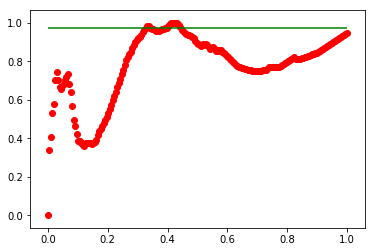

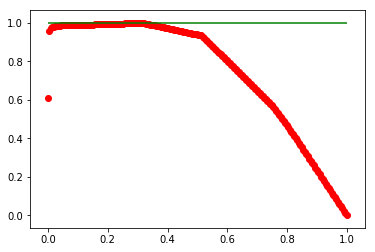

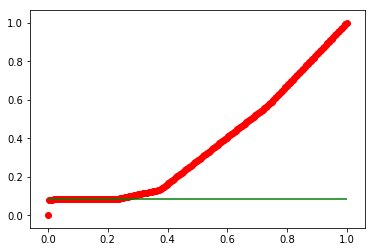

In [9]:
draw_ppl = load_ppl << ds
btch = draw_ppl.next_batch(12, shuffle=11)
for i in range(3):
    plt.scatter(btch.time_grid[i], btch.derivative_grid[i], c='r')
    plt.hlines(btch.norm_target[i], 0, 1, colors='g')
    plt.show()

# Обучение

In [10]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', kernel_size=[20, 20], filters=[10, 10]),
              'head': dict(layout='f', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5}),
             }

In [11]:
train_ppl = (load_ppl
              .init_variable('loss', init_on_each_run=0)
              .init_model('static', TFModel, 'baseline', config=model_config)
              .train_model('baseline', fetches='loss',
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('norm_target')},
                           save_to=V('loss'), mode='w')
             ) << ds.train

test_ppl = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .import_model('baseline', train_ppl)
                  .predict_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('norm_target')},
                                        save_to=[V('loss'), B('predictions')], mode='w')
                  .denormalize(src='predictions', dst='denorm_predictions', src_range='derivative_range')
                ) << ds.test
    
train_ppl.reset_iter()
test_ppl.reset_iter()

In [12]:
train_loss = []
test_loss = []

for i in tqdm(range(1000)):
    btch = train_ppl.next_batch(20, shuffle=True, n_epochs=None, drop_last=True)
    train_loss.append(train_ppl.get_variable('loss'))
    if i % 10 == 0:
        btch2 = test_ppl.next_batch(30, shuffle=True, n_epochs=None, drop_last=True)
        test_loss.append(test_ppl.get_variable('loss'))

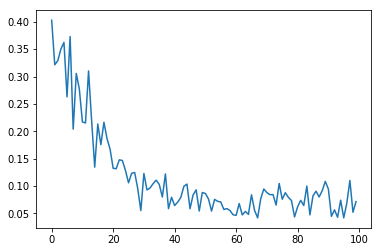

In [13]:
plt.plot(test_loss)

In [14]:
def exp(*args):
    return np.array(list(map(lambda x: 10 ** x, args)))

# Inference on the whole dataset

In [15]:
predicted_batches = []

predict_ppl = (load_ppl
              .init_variable('loss', init_on_each_run=0)
              .import_model('baseline', train_ppl)
              .predict_model('baseline', fetches=['loss', 'predictions'],
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('norm_target')},
                                    save_to=[V('loss'), B('predictions')], mode='w')
            ) << ds.test

btch = predict_ppl.next_batch(len(ds.test.indices))
predicted_batches.append(btch)

In [31]:
for btch in predicted_batches:
#     current = (np.abs(btch.predictions.reshape(-1) - btch.norm_target.reshape(-1)) / 
#                     (btch.norm_target.reshape(-1) + 1e-5))
    current = np.abs(btch.predictions.reshape(-1) - btch.norm_target.reshape(-1))
    metrics = (np.array(current, dtype=np.float32))

# Mean absolute error

In [38]:
np.mean(metrics)

0.19754682

# Histogram of absolute errors

[]

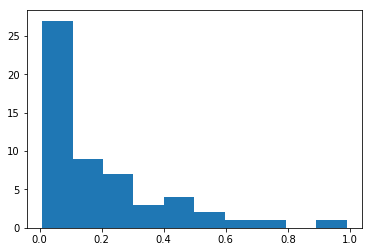

In [40]:
plt.hist(metrics[np.argsort(metrics)])
plt.plot()

# the best 

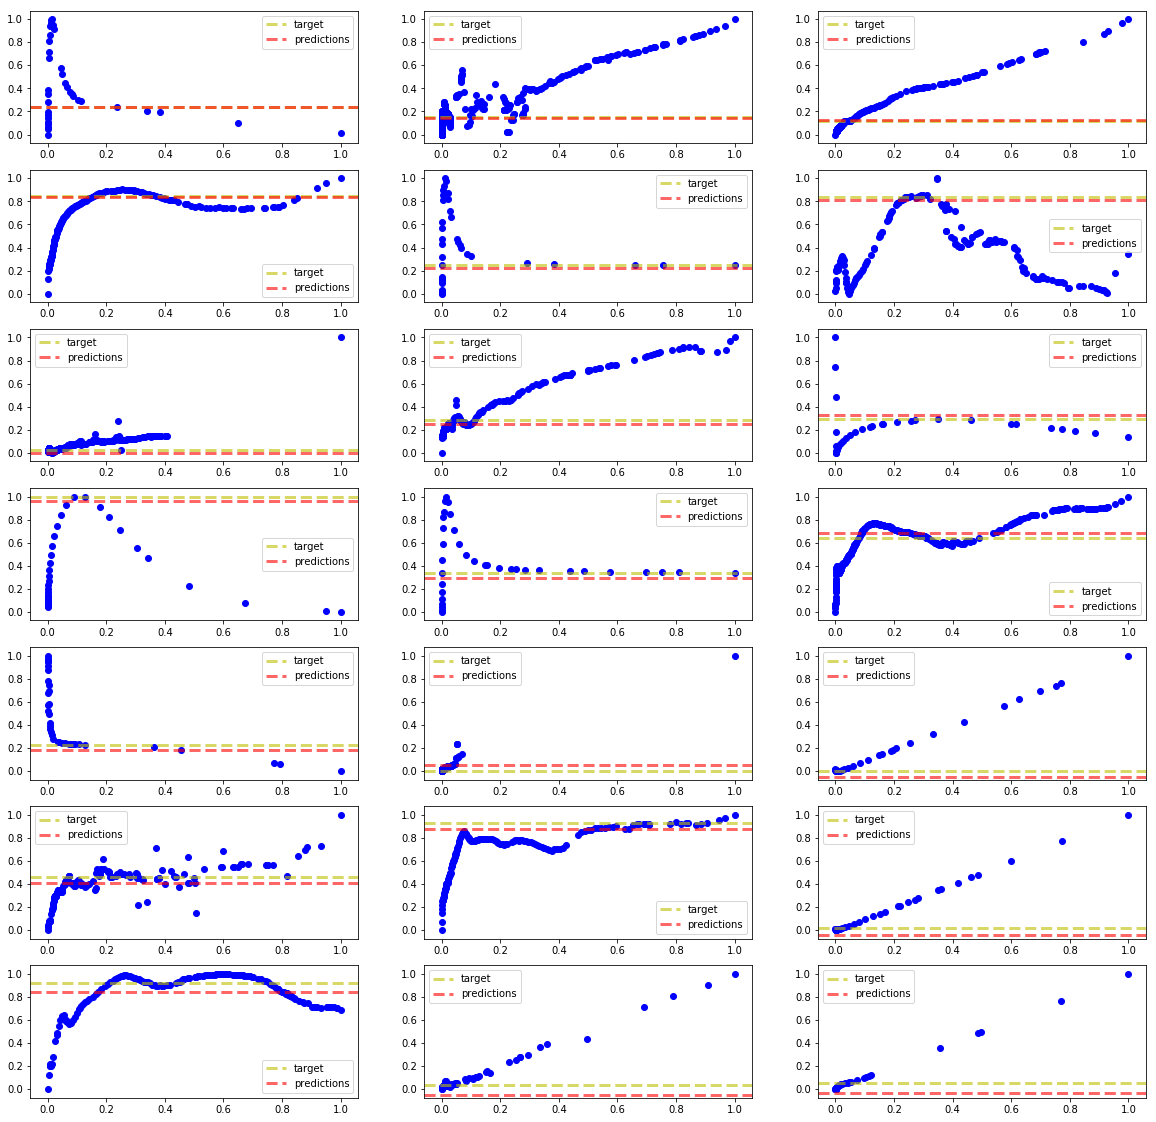

In [44]:
s = 0
ix = np.argsort(metrics)

target = btch.norm_target[ix]
predictions = btch.predictions[ix]
_, ax = plt.subplots(7, 3, figsize=(20, 20))
ax = ax.reshape(-1)
for i in range(s, s+21):
    x = btch.norm_time[ix][i]
    y = btch.norm_derivative[ix][i]


    ax[i-s].scatter(x, y, c='b')
    ax[i-s].axhline(target[i], ls='--', c='y', lw=3, alpha=0.6, label='target')
    ax[i-s].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[i-s].legend()

Let's habe a look at the worst

In [ ]:
s = 0
ix = np.argsort(metrics)

target = btch.norm_target[ix][::-1]
predictions = btch.predictions[ix][::-1]
_, ax = plt.subplots(4, 3, figsize=(20, 20))
ax = ax.reshape(-1)
for i in range(s, s+12):
    x = btch.norm_time[ix][::-1][i]
    y = btch.norm_derivative[ix][::-1][i]


    ax[i-s].scatter(x, y, c='b')
    ax[i-s].axhline(target[i], ls='--', c='y', lw=3, alpha=0.6, label='target')
    ax[i-s].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[i-s].legend()

# Conclusion

We have to carefully revise existing data